In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
from PIL import Image
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [19]:
# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
NUM_EPOCHS = 35
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create directories for saving models and plots
save_dir = 'model_checkpoints'
plot_dir = 'plots'
for directory in [save_dir, plot_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [20]:
# Define transforms for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetClassifier, self).__init__()
        # Change 1: Initialize without pre-trained weights
        self.resnet = models.resnet50(weights=None)
        
        # Change 2: More complex classifier with higher dropout
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [22]:
# Cell [4] - Add class mapping print
# Check and load dataset
dataset_path = './COVID-19_Radiography_Dataset'
if not os.path.exists(dataset_path):
    raise ValueError(f"Dataset path {dataset_path} does not exist!")

dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
if len(dataset) == 0:
    raise ValueError("No images found in the dataset directory")

# Print class mapping to verify classes
print("Class mapping:", dataset.class_to_idx)

# Rest of the cell remains the same
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, 
                                                         [train_size, val_size],
                                                         generator=generator)

# Change 7: Update data loaders with better settings
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,  # Increased workers
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

Class mapping: {'covid': 0, 'normal': 1, 'pneumonia': 2}


In [23]:
model = ResNetClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
# Change 3: Update optimizer settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,  # Lower learning rate
    weight_decay=0.01  # Add weight decay
)

# Change 4: Update learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    
)

In [24]:
# New Cell - Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model, path='model_checkpoints/best_model_early_stop.pth'):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

Using device: cuda
Training samples: 12122
Validation samples: 3031

Starting training...


Epoch 1/50 - Learning Rate: 0.000100


Epoch 1/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.7026 | Accuracy: 69.16%
Validation  - Loss: 0.6573 | Accuracy: 72.35%
Validation loss decreased (inf --> 0.657252). Saving model...
------------------------------------------------------------

Epoch 2/50 - Learning Rate: 0.000100


Epoch 2/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.5512 | Accuracy: 75.61%
Validation  - Loss: 0.5444 | Accuracy: 78.23%
Validation loss decreased (0.657252 --> 0.544436). Saving model...
------------------------------------------------------------

Epoch 3/50 - Learning Rate: 0.000100


Epoch 3/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.4869 | Accuracy: 79.47%
Validation  - Loss: 0.4496 | Accuracy: 82.05%
Validation loss decreased (0.544436 --> 0.449639). Saving model...
------------------------------------------------------------

Epoch 4/50 - Learning Rate: 0.000100


Epoch 4/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.4323 | Accuracy: 82.66%
Validation  - Loss: 0.3988 | Accuracy: 83.54%
Validation loss decreased (0.449639 --> 0.398784). Saving model...
------------------------------------------------------------

Epoch 5/50 - Learning Rate: 0.000100


Epoch 5/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.3951 | Accuracy: 84.38%
Validation  - Loss: 0.3447 | Accuracy: 85.38%
Validation loss decreased (0.398784 --> 0.344702). Saving model...
------------------------------------------------------------

Epoch 6/50 - Learning Rate: 0.000100


Epoch 6/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.3589 | Accuracy: 86.26%
Validation  - Loss: 0.3167 | Accuracy: 87.92%
Validation loss decreased (0.344702 --> 0.316679). Saving model...
------------------------------------------------------------

Epoch 7/50 - Learning Rate: 0.000100


Epoch 7/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.3342 | Accuracy: 87.74%
Validation  - Loss: 0.3133 | Accuracy: 87.73%
Validation loss decreased (0.316679 --> 0.313287). Saving model...
------------------------------------------------------------

Epoch 8/50 - Learning Rate: 0.000100


Epoch 8/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.3157 | Accuracy: 88.59%
Validation  - Loss: 0.2697 | Accuracy: 89.71%
Validation loss decreased (0.313287 --> 0.269656). Saving model...
------------------------------------------------------------

Epoch 9/50 - Learning Rate: 0.000100


Epoch 9/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.3045 | Accuracy: 88.77%
Validation  - Loss: 0.2995 | Accuracy: 88.29%
EarlyStopping counter: 1 out of 7
------------------------------------------------------------

Epoch 10/50 - Learning Rate: 0.000100


Epoch 10/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2833 | Accuracy: 90.04%
Validation  - Loss: 0.3168 | Accuracy: 88.25%
EarlyStopping counter: 2 out of 7
------------------------------------------------------------

Epoch 11/50 - Learning Rate: 0.000100


Epoch 11/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2769 | Accuracy: 90.01%
Validation  - Loss: 0.2805 | Accuracy: 91.45%
EarlyStopping counter: 3 out of 7
------------------------------------------------------------

Epoch 12/50 - Learning Rate: 0.000100


Epoch 12/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2652 | Accuracy: 90.98%
Validation  - Loss: 0.2055 | Accuracy: 92.77%
Validation loss decreased (0.269656 --> 0.205513). Saving model...
------------------------------------------------------------

Epoch 13/50 - Learning Rate: 0.000100


Epoch 13/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2582 | Accuracy: 91.13%
Validation  - Loss: 0.2041 | Accuracy: 92.08%
Validation loss decreased (0.205513 --> 0.204111). Saving model...
------------------------------------------------------------

Epoch 14/50 - Learning Rate: 0.000100


Epoch 14/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2527 | Accuracy: 91.54%
Validation  - Loss: 0.1874 | Accuracy: 93.24%
Validation loss decreased (0.204111 --> 0.187412). Saving model...
------------------------------------------------------------

Epoch 15/50 - Learning Rate: 0.000100


Epoch 15/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2531 | Accuracy: 91.59%
Validation  - Loss: 0.2754 | Accuracy: 89.57%
EarlyStopping counter: 1 out of 7
------------------------------------------------------------

Epoch 16/50 - Learning Rate: 0.000100


Epoch 16/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2384 | Accuracy: 91.74%
Validation  - Loss: 0.2091 | Accuracy: 93.40%
EarlyStopping counter: 2 out of 7
------------------------------------------------------------

Epoch 17/50 - Learning Rate: 0.000100


Epoch 17/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2380 | Accuracy: 92.21%
Validation  - Loss: 0.2017 | Accuracy: 93.30%
EarlyStopping counter: 3 out of 7
------------------------------------------------------------

Epoch 18/50 - Learning Rate: 0.000100


Epoch 18/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2264 | Accuracy: 92.41%
Validation  - Loss: 0.2202 | Accuracy: 91.95%
EarlyStopping counter: 4 out of 7
------------------------------------------------------------

Epoch 19/50 - Learning Rate: 0.000100


Epoch 19/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2148 | Accuracy: 92.68%
Validation  - Loss: 0.2148 | Accuracy: 92.38%
EarlyStopping counter: 5 out of 7
------------------------------------------------------------

Epoch 20/50 - Learning Rate: 0.000100


Epoch 20/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2172 | Accuracy: 93.51%
Validation  - Loss: 0.1847 | Accuracy: 93.63%
Validation loss decreased (0.187412 --> 0.184669). Saving model...
------------------------------------------------------------

Epoch 21/50 - Learning Rate: 0.000100


Epoch 21/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2179 | Accuracy: 93.23%
Validation  - Loss: 0.1710 | Accuracy: 93.83%
Validation loss decreased (0.184669 --> 0.170979). Saving model...
------------------------------------------------------------

Epoch 22/50 - Learning Rate: 0.000100


Epoch 22/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2096 | Accuracy: 93.37%
Validation  - Loss: 0.2085 | Accuracy: 92.91%
EarlyStopping counter: 1 out of 7
------------------------------------------------------------

Epoch 23/50 - Learning Rate: 0.000100


Epoch 23/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2099 | Accuracy: 93.26%
Validation  - Loss: 0.1856 | Accuracy: 94.42%
EarlyStopping counter: 2 out of 7
------------------------------------------------------------

Epoch 24/50 - Learning Rate: 0.000100


Epoch 24/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1954 | Accuracy: 93.90%
Validation  - Loss: 0.2032 | Accuracy: 94.09%
EarlyStopping counter: 3 out of 7
------------------------------------------------------------

Epoch 25/50 - Learning Rate: 0.000100


Epoch 25/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1981 | Accuracy: 93.94%
Validation  - Loss: 0.1965 | Accuracy: 94.13%
EarlyStopping counter: 4 out of 7
------------------------------------------------------------

Epoch 26/50 - Learning Rate: 0.000100


Epoch 26/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.2048 | Accuracy: 93.67%
Validation  - Loss: 0.1827 | Accuracy: 93.90%
EarlyStopping counter: 5 out of 7
------------------------------------------------------------

Epoch 27/50 - Learning Rate: 0.000100


Epoch 27/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1959 | Accuracy: 94.25%
Validation  - Loss: 0.1852 | Accuracy: 94.13%
Learning rate decreased to 0.000010
EarlyStopping counter: 6 out of 7
------------------------------------------------------------

Epoch 28/50 - Learning Rate: 0.000010


Epoch 28/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1489 | Accuracy: 95.63%
Validation  - Loss: 0.1435 | Accuracy: 95.61%
Validation loss decreased (0.170979 --> 0.143460). Saving model...
------------------------------------------------------------

Epoch 29/50 - Learning Rate: 0.000010


Epoch 29/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1270 | Accuracy: 96.29%
Validation  - Loss: 0.1235 | Accuracy: 96.70%
Validation loss decreased (0.143460 --> 0.123460). Saving model...
------------------------------------------------------------

Epoch 30/50 - Learning Rate: 0.000010


Epoch 30/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1281 | Accuracy: 96.27%
Validation  - Loss: 0.1220 | Accuracy: 96.54%
Validation loss decreased (0.123460 --> 0.121982). Saving model...
------------------------------------------------------------

Epoch 31/50 - Learning Rate: 0.000010


Epoch 31/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1277 | Accuracy: 96.35%
Validation  - Loss: 0.1426 | Accuracy: 96.04%
EarlyStopping counter: 1 out of 7
------------------------------------------------------------

Epoch 32/50 - Learning Rate: 0.000010


Epoch 32/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1267 | Accuracy: 96.47%
Validation  - Loss: 0.1262 | Accuracy: 96.27%
EarlyStopping counter: 2 out of 7
------------------------------------------------------------

Epoch 33/50 - Learning Rate: 0.000010


Epoch 33/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1186 | Accuracy: 96.61%
Validation  - Loss: 0.1472 | Accuracy: 96.34%
EarlyStopping counter: 3 out of 7
------------------------------------------------------------

Epoch 34/50 - Learning Rate: 0.000010


Epoch 34/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1238 | Accuracy: 96.68%
Validation  - Loss: 0.1325 | Accuracy: 96.70%
EarlyStopping counter: 4 out of 7
------------------------------------------------------------

Epoch 35/50 - Learning Rate: 0.000010


Epoch 35/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1202 | Accuracy: 96.77%
Validation  - Loss: 0.1280 | Accuracy: 96.57%
EarlyStopping counter: 5 out of 7
------------------------------------------------------------

Epoch 36/50 - Learning Rate: 0.000010


Epoch 36/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1163 | Accuracy: 96.86%
Validation  - Loss: 0.1459 | Accuracy: 96.34%
Learning rate decreased to 0.000001
EarlyStopping counter: 6 out of 7
------------------------------------------------------------

Epoch 37/50 - Learning Rate: 0.000001


Epoch 37/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1066 | Accuracy: 97.09%
Validation  - Loss: 0.1181 | Accuracy: 97.26%
Validation loss decreased (0.121982 --> 0.118127). Saving model...
------------------------------------------------------------

Epoch 38/50 - Learning Rate: 0.000001


Epoch 38/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1039 | Accuracy: 97.23%
Validation  - Loss: 0.1267 | Accuracy: 96.83%
EarlyStopping counter: 1 out of 7
------------------------------------------------------------

Epoch 39/50 - Learning Rate: 0.000001


Epoch 39/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1049 | Accuracy: 97.20%
Validation  - Loss: 0.1336 | Accuracy: 96.73%
EarlyStopping counter: 2 out of 7
------------------------------------------------------------

Epoch 40/50 - Learning Rate: 0.000001


Epoch 40/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1128 | Accuracy: 96.93%
Validation  - Loss: 0.1322 | Accuracy: 96.44%
EarlyStopping counter: 3 out of 7
------------------------------------------------------------

Epoch 41/50 - Learning Rate: 0.000001


Epoch 41/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1138 | Accuracy: 97.01%
Validation  - Loss: 0.1321 | Accuracy: 96.60%
EarlyStopping counter: 4 out of 7
------------------------------------------------------------

Epoch 42/50 - Learning Rate: 0.000001


Epoch 42/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1031 | Accuracy: 97.34%
Validation  - Loss: 0.1256 | Accuracy: 96.93%
EarlyStopping counter: 5 out of 7
------------------------------------------------------------

Epoch 43/50 - Learning Rate: 0.000001


Epoch 43/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1121 | Accuracy: 97.14%
Validation  - Loss: 0.1356 | Accuracy: 96.67%
Learning rate decreased to 0.000000
EarlyStopping counter: 6 out of 7
------------------------------------------------------------

Epoch 44/50 - Learning Rate: 0.000000


Epoch 44/50:   0%|                    | 0/758 [00:00<?, ?it/s]

Training    - Loss: 0.1017 | Accuracy: 96.98%
Validation  - Loss: 0.1309 | Accuracy: 96.77%
EarlyStopping counter: 7 out of 7

Early stopping triggered!

Training completed!


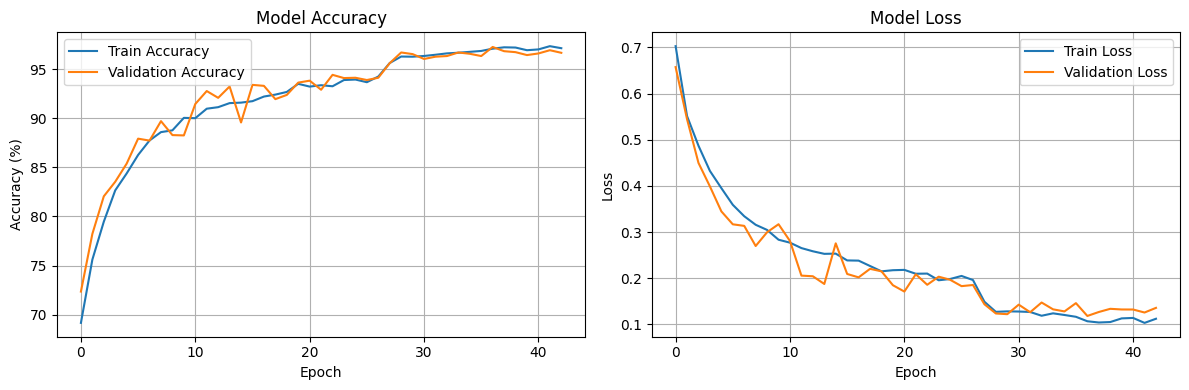

In [25]:
# Define training parameters
BATCH_SIZE = 32  # Increased from 16
NUM_EPOCHS = 50  # Increased from 35
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modified Training Loop Cell with Progress Bar and Metrics
from tqdm.notebook import tqdm

try:
    # Initialize history trackers
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=7, verbose=True)

    # Verify model and data are on correct device
    model = model.to(DEVICE)
    print(f"Using device: {DEVICE}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")

    # Training loop with progress bars
    print("\nStarting training...\n")

    for epoch in range(NUM_EPOCHS):
        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} - Learning Rate: {current_lr:.6f}")
        
        # Initialize epoch stats
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Progress bar for training
        epoch_pbar = tqdm(total=len(train_loader),
                         desc=f'Epoch {epoch+1}/{NUM_EPOCHS}',
                         bar_format='{l_bar}{bar:20}{r_bar}')
        
        # Training phase
        model.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            try:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping (new)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Optimizer step
                optimizer.step()
                
                # Calculate metrics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
                
                # Calculate current training metrics
                current_train_acc = 100. * train_correct / train_total
                current_train_loss = train_loss / (batch_idx + 1)
                
                # Update progress bar with training metrics
                epoch_pbar.set_postfix({
                    'Loss': f'{current_train_loss:.4f}',
                    'Train Acc': f'{current_train_acc:.2f}%'
                })
                epoch_pbar.update(1)
                
            except Exception as e:
                print(f"\nError in training batch {batch_idx}: {e}")
                continue
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(DEVICE), val_labels.to(DEVICE)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += val_predicted.eq(val_labels).sum().item()
        
        # Calculate final metrics
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # Close progress bar
        epoch_pbar.close()
        
        # Print detailed metrics
        print(f'Training    - Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%')
        print(f'Validation  - Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%')
        
        # Update scheduler with validation loss
        scheduler.step(val_loss)
        
        # Print if learning rate changed
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate decreased to {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("\nEarly stopping triggered!")
            break
        
        # Update history
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        print('-' * 60)

    print("\nTraining completed!")

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nFatal error in training loop: {e}")
    raise

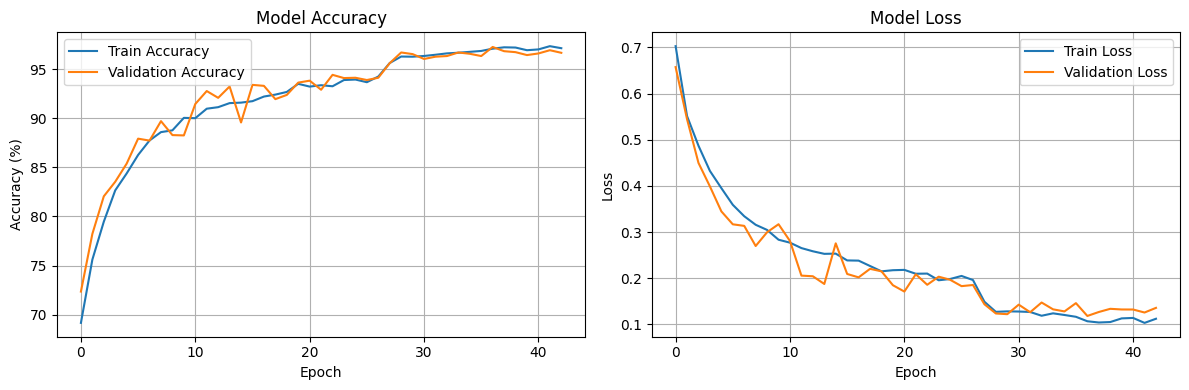

In [26]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Model Evaluation:


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 265/265 [03:53<00:00,  1.13it/s]



Classification Report:
              precision    recall  f1-score   support

Lung_Opacity       0.91      0.89      0.90      1215
       covid       0.94      0.94      0.94       727
      normal       0.93      0.95      0.94      2039
   pneumonia       0.96      0.93      0.95       252

    accuracy                           0.93      4233
   macro avg       0.94      0.93      0.93      4233
weighted avg       0.93      0.93      0.93      4233



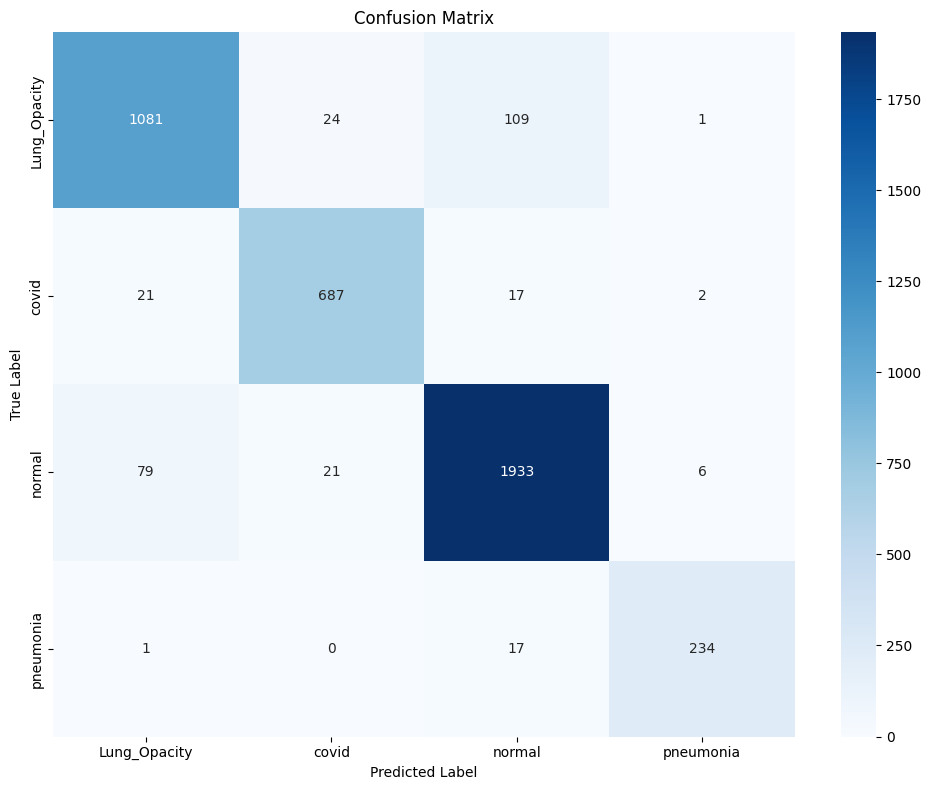


Detailed Metrics:


Calculating metrics: 100%|███████████████████████████████████████████████████████████| 265/265 [01:00<00:00,  4.38it/s]


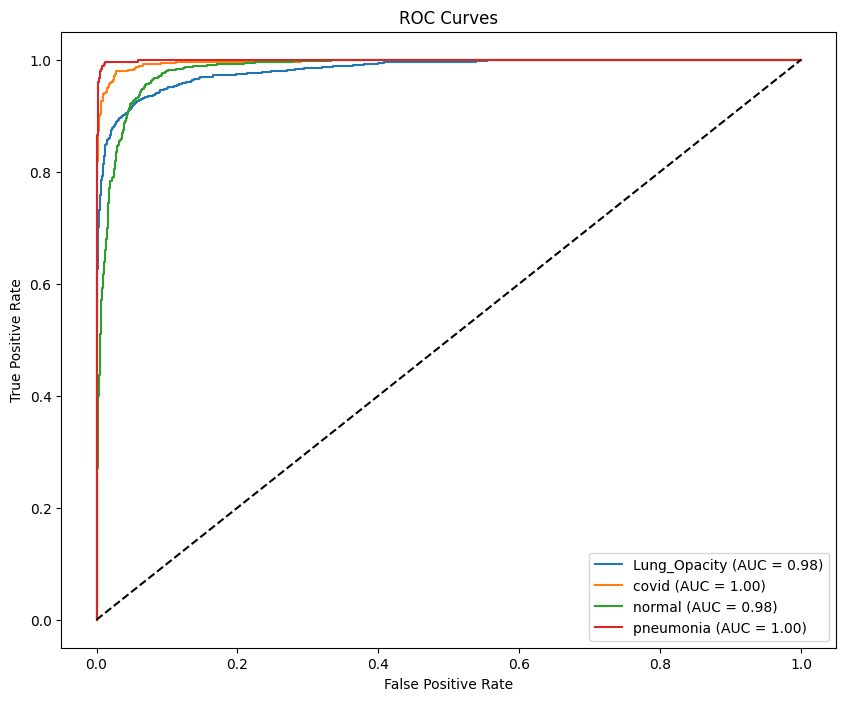

In [14]:
# Model evaluation functions
def evaluate_model(model, loader):
    """
    Evaluate the model on the given loader and print classification report
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # Progress bar for evaluation
    eval_bar = tqdm(total=len(loader), desc='Evaluating')
    
    with torch.no_grad():
        for inputs, labels in loader:
            try:
                # Move inputs to device
                inputs = inputs.to(DEVICE)
                
                # Forward pass
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                # Store predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
                
                eval_bar.update(1)
                
            except Exception as e:
                print(f"Error in evaluation batch: {e}")
                continue
    
    eval_bar.close()
    
    try:
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=dataset.classes))
        
        # Calculate confusion matrix
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=dataset.classes,
                   yticklabels=dataset.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating evaluation metrics: {e}")


def evaluate_model_metrics(model, loader):
    """
    Calculate detailed metrics for model evaluation
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Calculating metrics'):
            try:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                
                all_probs.extend(probabilities.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
                
            except Exception as e:
                print(f"Error in metric calculation: {e}")
                continue
    
    try:
        from sklearn.metrics import roc_curve, auc
        
        # Convert to numpy arrays
        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)
        
        # Plot ROC curves
        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(dataset.classes):
            fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc='lower right')
        plt.show()
        
    except Exception as e:
        print(f"Error plotting ROC curves: {e}")

# Example usage in Jupyter notebook:
# Evaluate the model
print("Model Evaluation:")
evaluate_model(model, val_loader)

# Calculate detailed metrics
print("\nDetailed Metrics:")
evaluate_model_metrics(model, val_loader)

# Example of single image prediction
# predict_image('path/to/your/image.jpg')

In [18]:
def predict_image(image_path):
    """
    Predict class for a single image
    """
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')  # Convert to RGB
        image_tensor = val_transform(image).unsqueeze(0).to(DEVICE)
        
        # Set model to evaluation mode
        model.eval()
        
        # Make prediction
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            probability, predicted = torch.max(probabilities, 1)
            
            # Get prediction and probability
            predicted_class = dataset.classes[predicted.item()]
            confidence = probability.item()
            
            # Print results
            print(f"Predicted class: {predicted_class}")
            print(f"Confidence: {confidence:.2%}")
            
            # Show image with prediction
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.title(f'Prediction: {predicted_class} ({confidence:.2%})')
            plt.axis('off')
            plt.show()
            
            return predicted_class, confidence
            
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 265/265 [00:56<00:00,  4.66it/s]



Classification Report:
              precision    recall  f1-score   support

Lung_Opacity       0.91      0.89      0.90      1215
       covid       0.97      0.94      0.96       727
      normal       0.93      0.95      0.94      2039
   pneumonia       0.98      0.93      0.95       252

    accuracy                           0.93      4233
   macro avg       0.95      0.93      0.94      4233
weighted avg       0.93      0.93      0.93      4233



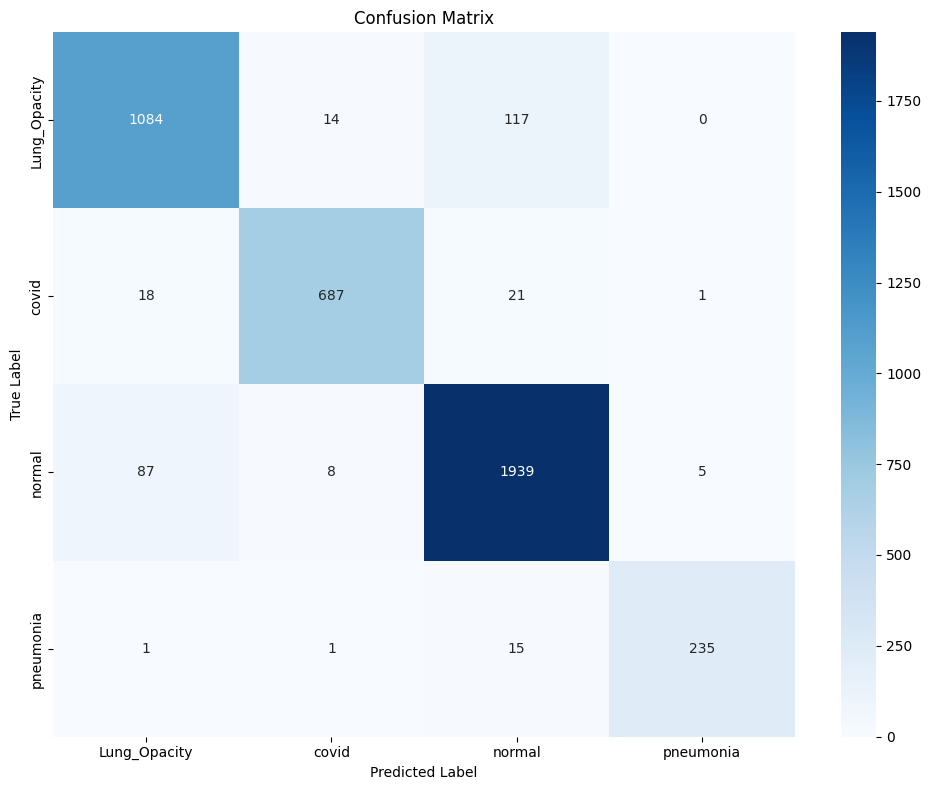

Calculating metrics: 100%|███████████████████████████████████████████████████████████| 265/265 [01:00<00:00,  4.35it/s]


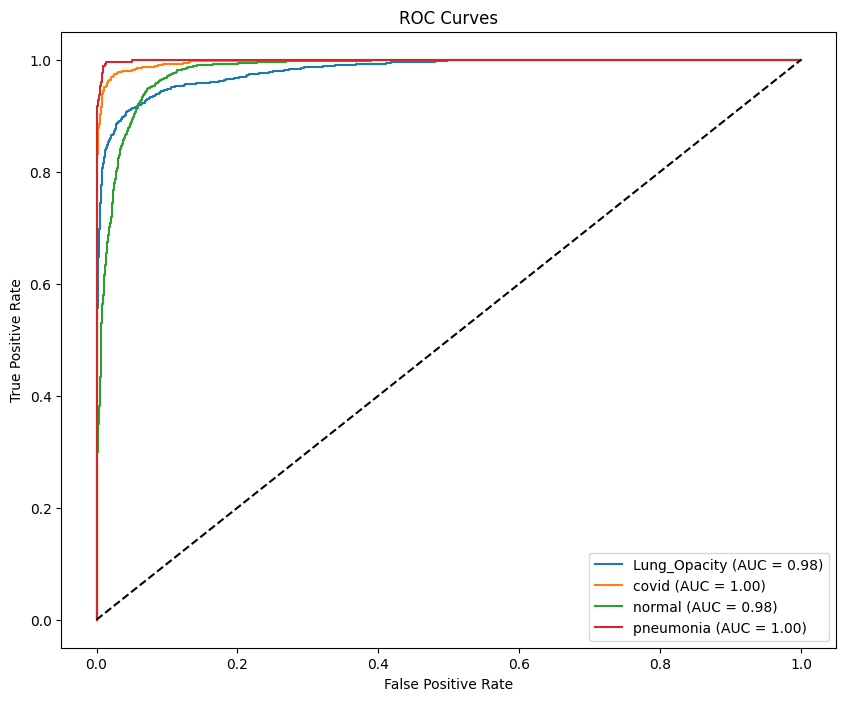

Error predicting image: [Errno 2] No such file or directory: 'C:\\Users\\lohit\\Desktop\\covid_project\\path\\to\\image.jpg'


(None, None)

In [15]:
# For overall evaluation
evaluate_model(model, val_loader)

# For detailed metrics
evaluate_model_metrics(model, val_loader)


<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
C:\Users\lohit\AppData\Local\Temp\ipykernel_23620\3545866161.py:4: SyntaxWarning: invalid escape sequence '\L'
  predict_image('COVID-19_Radiography_Dataset\Lung_Opacity\images\Lung_Opacity-1.png')


Predicted class: covid
Confidence: 99.65%


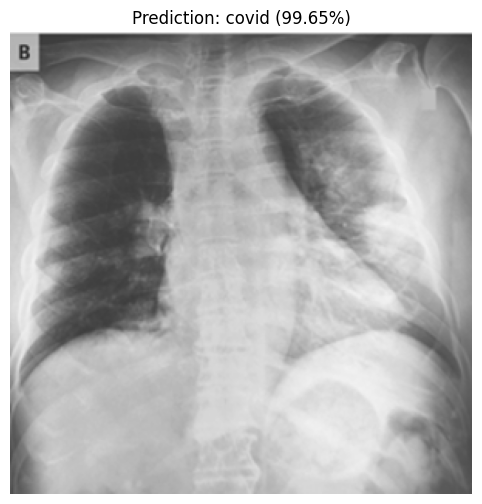

Predicted class: covid
Confidence: 99.99%


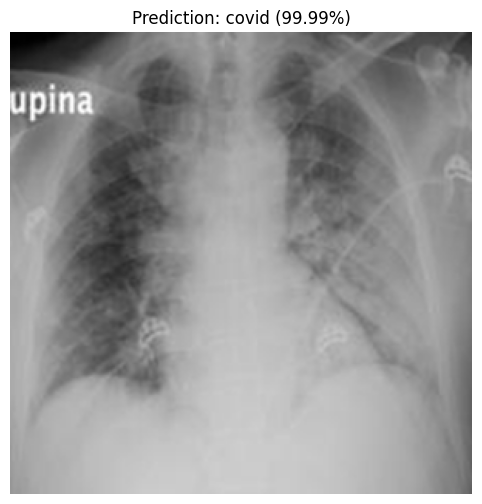

Predicted class: Lung_Opacity
Confidence: 99.99%


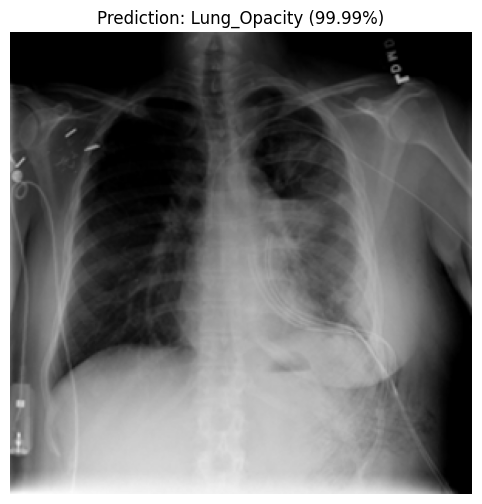

('Lung_Opacity', 0.9999094009399414)

In [21]:
# For single image prediction
predict_image('COVID-19_Radiography_Dataset/covid/images/COVID-5.png')
predict_image('COVID-19_Radiography_Dataset/covid/images/COVID-50.png')
predict_image('COVID-19_Radiography_Dataset\Lung_Opacity\images\Lung_Opacity-1.png')

To save the model

In [22]:
import h5py

In [23]:
def save_model_h5(model, save_path='model_checkpoints/covid_classifier_resnet.h5'):
    """
    Save the model as H5 file
    """
    try:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # Save model
        torch.save(model.state_dict(), save_path)
        print(f"Model saved successfully to {save_path}")
        
    except Exception as e:
        print(f"Error saving model: {e}")

# Save the model
save_model_h5(model)

Model saved successfully to model_checkpoints/covid_classifier_resnet.h5


In [24]:
def load_model_h5(load_path='model_checkpoints/covid_classifier_resnet.h5'):
    """
    Load the model from H5 file
    """
    try:
        # Create new model instance
        model = ResNetClassifier()
        
        # Load weights
        model.load_state_dict(torch.load(load_path))
        model = model.to(DEVICE)
        
        print(f"Model loaded successfully from {load_path}")
        return model
            
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# To load the saved model:
# loaded_model = load_model_h5()